<a href="https://colab.research.google.com/github/aks-vijay/Apache-Spark/blob/main/Ingest_%26_Wrangle_2015_Street_Tree_Census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58749 sha256=88d4aedf5d108f55490185b89e91d0fbc1e1a4c7f73a10a19e90c7a51eb7042d
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d6e89cf07a48e7aeb0a3609d32940c6150f262de34348a8ce4e4405d4497d6ba
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession  \
          .builder \
          .appName("TreeDataCleaningApp") \
          .master("local[*]") \
          .getOrCreate()

spark.conf.set("spark.sql.adaptive.enabled", True)

In [13]:
df_raw = spark.read \
                .option("inferSchema", True) \
                .option("header", True) \
                .csv("/2015_Street_Tree_Census_-_Tree_Data_20240411.csv")


columns_to_select = ['tree_id',
                        'tree_dbh',
                        'stump_diam',
                        'curb_loc',
                        'status',
                        'health',
                        'spc_latin',
                        'steward',
                        'guards',
                        'sidewalk',
                        'problems',
                        'root_stone',
                        'root_grate',
                        'root_other',
                        'trunk_wire',
                        'trnk_light',
                        'trnk_other',
                        'brch_light',
                        'brch_shoe',
                        'brch_other']

df_raw_subset = df_raw.select(*columns_to_select)


# Data Exploration

In [14]:
df_raw_subset.toPandas().isna().sum()

tree_id           0
tree_dbh          0
stump_diam        0
curb_loc          0
status            0
health        31616
spc_latin     31619
steward       31615
guards        31616
sidewalk      31616
problems      31664
root_stone        0
root_grate        0
root_other        0
trunk_wire        0
trnk_light        0
trnk_other        0
brch_light        0
brch_shoe         0
brch_other        0
dtype: int64

In [15]:
from pyspark.sql.functions import *
df_raw_subset \
  .select(col("*")) \
  .where(col("health").isNull()) \
  .show()

+-------+--------+----------+--------+------+------+---------+-------+------+--------+--------+----------+----------+----------+----------+----------+----------+----------+---------+----------+
|tree_id|tree_dbh|stump_diam|curb_loc|status|health|spc_latin|steward|guards|sidewalk|problems|root_stone|root_grate|root_other|trunk_wire|trnk_light|trnk_other|brch_light|brch_shoe|brch_other|
+-------+--------+----------+--------+------+------+---------+-------+------+--------+--------+----------+----------+----------+----------+----------+----------+----------+---------+----------+
| 211205|       0|        16|  OnCurb| Stump|  NULL|     NULL|   NULL|  NULL|    NULL|    NULL|        No|        No|        No|        No|        No|        No|        No|       No|        No|
| 187807|       0|         0|  OnCurb|  Dead|  NULL|     NULL|   NULL|  NULL|    NULL|    NULL|        No|        No|        No|        No|        No|        No|        No|       No|        No|
| 208322|      10|         0| 

In [16]:
df_raw_subset.describe().show()

+-------+------------------+-----------------+-------------------+--------------+------+------+---------------+-------+-------+--------+--------------------+----------+----------+----------+----------+----------+----------+----------+---------+----------+
|summary|           tree_id|         tree_dbh|         stump_diam|      curb_loc|status|health|      spc_latin|steward| guards|sidewalk|            problems|root_stone|root_grate|root_other|trunk_wire|trnk_light|trnk_other|brch_light|brch_shoe|brch_other|
+-------+------------------+-----------------+-------------------+--------------+------+------+---------------+-------+-------+--------+--------------------+----------+----------+----------+----------+----------+----------+----------+---------+----------+
|  count|            683788|           683788|             683788|        683788|683788|652172|         652169| 652173| 652172|  652172|              652124|    683788|    683788|    683788|    683788|    683788|    683788|    68378

# Check how values are distributed

array([[<Axes: title={'center': 'tree_id'}>,
        <Axes: title={'center': 'tree_dbh'}>],
       [<Axes: title={'center': 'stump_diam'}>, <Axes: >]], dtype=object)

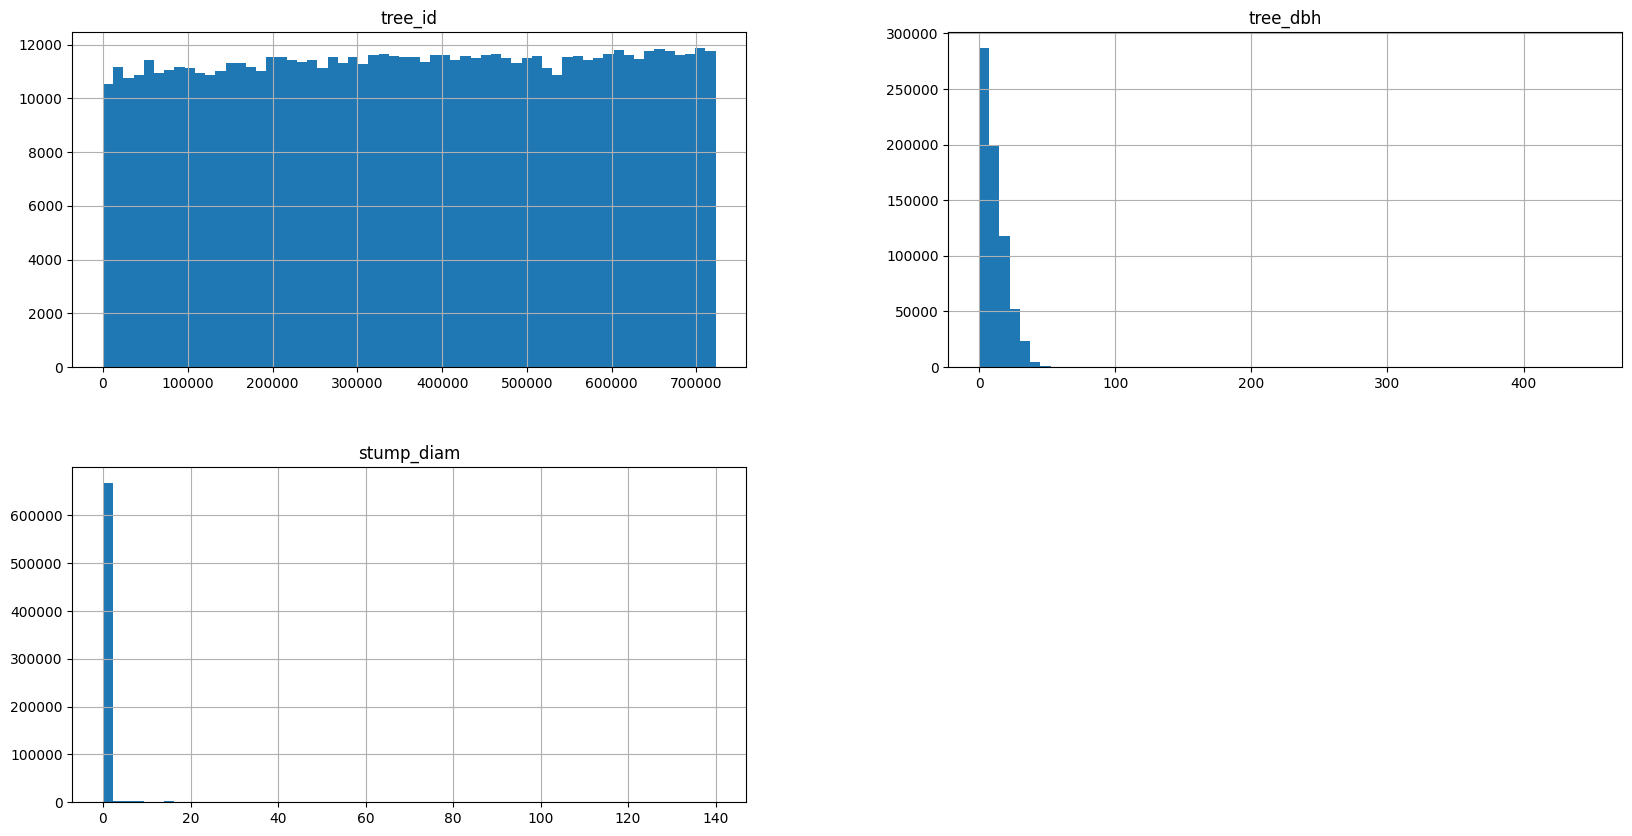

In [17]:
df_raw_subset.toPandas().hist(bins=60, figsize=(20,10))

### There could be some errors in data collection. Hence we visualize each column to identify those values

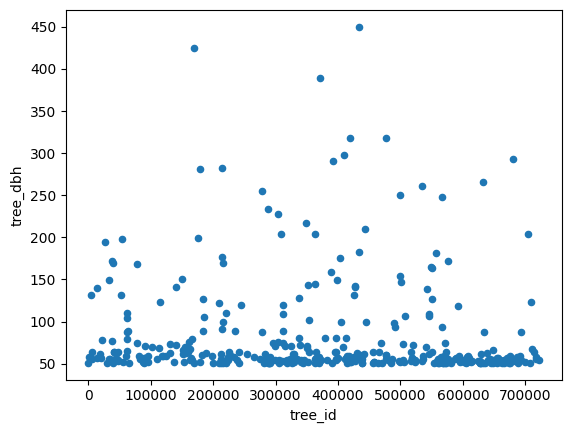

In [18]:
def visualize_diameter(col_name):
  df_raw_subset \
    .where(col(col_name)  > 50) \
    .select("tree_id", col_name) \
    .toPandas() \
    .plot(kind="scatter", x="tree_id", y=col_name)

visualize_diameter("tree_dbh")

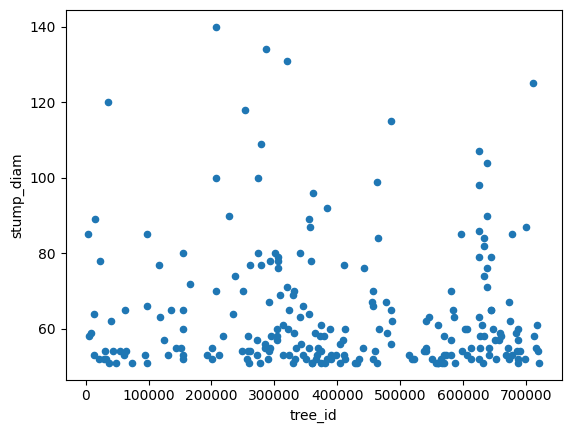

In [19]:
visualize_diameter("stump_diam")

<Axes: >

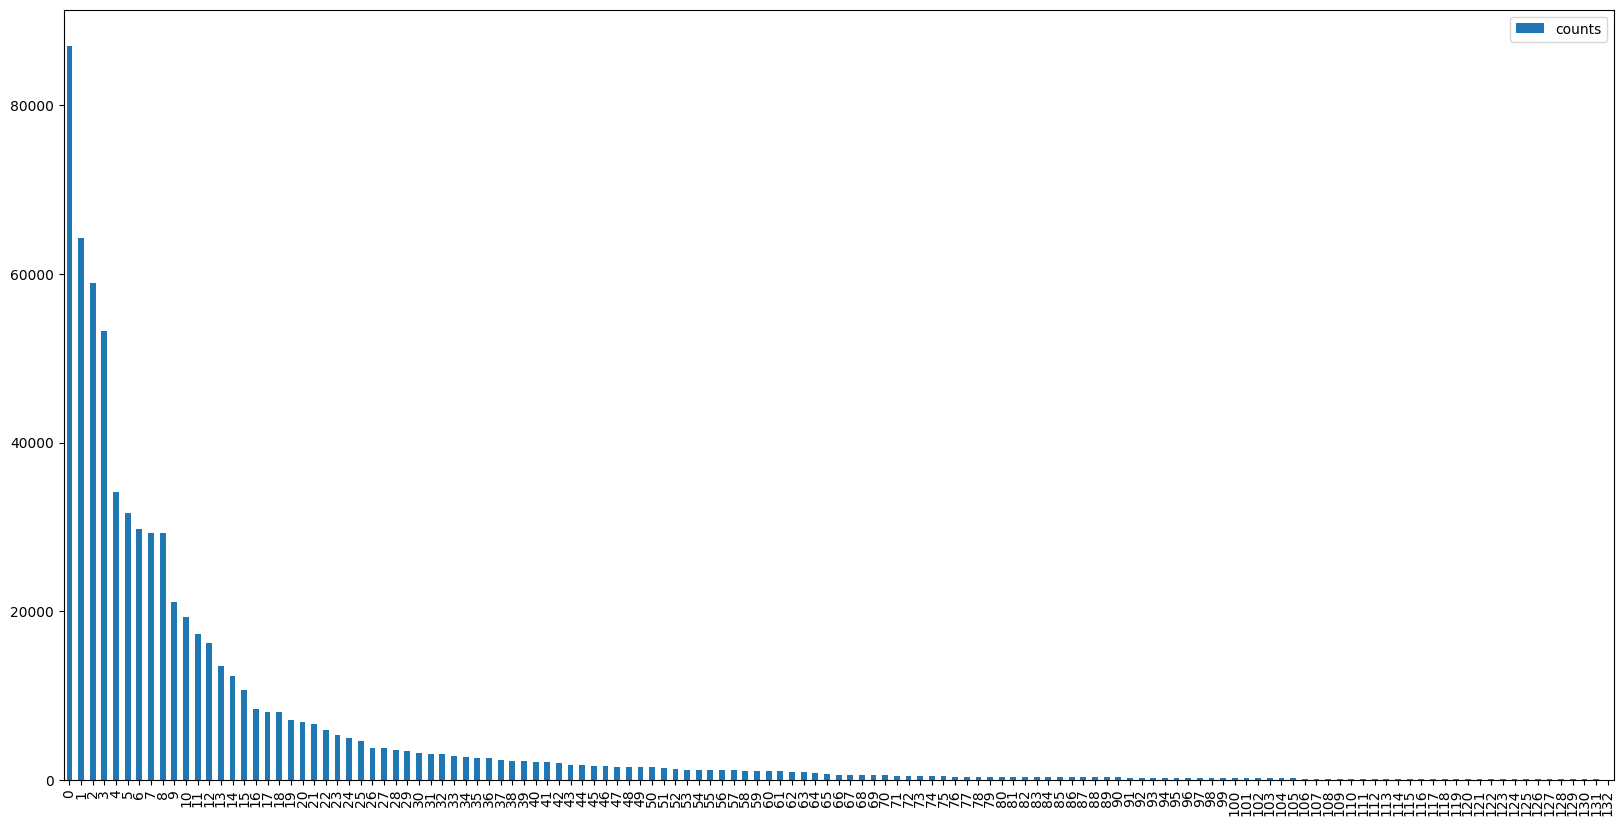

In [20]:
df_spc_latin = df_raw_subset \
                .groupBy("spc_latin") \
                .agg(
                    count("*").alias("counts")
                ) \
                .orderBy("counts", ascending=False)

df_spc_latin.toPandas().plot(kind="bar", figsize=(20,10))

In [21]:
def value_counts(col_name: str) -> DataFrame:
  """
  function which creates value_counts similar to pandas
  """
  df_raw_subset \
    .groupBy(col_name) \
    .agg(
        count("*").alias("count")
    ) \
    .orderBy("count", ascending=False) \
    .show()

value_counts("steward")

+-------+------+
|steward| count|
+-------+------+
|   None|487823|
|   1or2|143557|
|   NULL| 31615|
|   3or4| 19183|
|4orMore|  1610|
+-------+------+



In [22]:
value_counts("sidewalk")

+--------+------+
|sidewalk| count|
+--------+------+
|NoDamage|464978|
|  Damage|187194|
|    NULL| 31616|
+--------+------+



In [23]:
value_counts("health")

+------+------+
|health| count|
+------+------+
|  Good|528850|
|  Fair| 96504|
|  NULL| 31616|
|  Poor| 26818|
+------+------+



# Identify NULLs and fill with NAs for the below columns

In [29]:
# identify if status is stump or dead -> fill not applicable
columns_to_full_na = ["steward", "guards"]
df_filled = df_raw_subset \
                  .where((col("status") == "Stump") | (col("status") == "Dead")) \
                  .fillna("Not Applicable", subset=columns_to_full_na)

# fetch status which are not stump or dead (good ones)
df_notfilled = df_raw_subset \
                  .where((col("status") != "Stump") & (col("status") != "Dead"))

# combine both the above dataframe for final version
df_filled_na = df_notfilled.union(df_filled)

df_filled = df_filled_na \
                .select(
                    col("tree_id"),
                    col("tree_dbh"),
                    col("stump_diam"),
                    col("curb_loc"),
                    col("status"),
                    when(df_filled_na.health.isNull(), "Good").otherwise(df_filled_na.health).alias("health"),
                    when(df_filled_na.spc_latin.isNull(), "No observation").otherwise(df_filled_na.spc_latin).alias("spc_latin"),
                    col("steward"),
                    col("guards"),
                    when(col("sidewalk").isNull(), "NoDamage").otherwise(col("sidewalk")).alias("sidewalk"),
                    when(col("problems").isNull(), "None").otherwise(col("problems")).alias("problems"),
                    col("root_stone"),
                    col("root_grate"),
                    col("root_other"),
                    col("trunk_wire"),
                    col("trnk_light"),
                    col("trnk_other"),
                    col("brch_light"),
                    col("brch_shoe"),
                    col("brch_other")
                )

# Split the main dataset into multiple dataset based on categories

In [44]:
# exclude the outliers
df_exclude_outliers = df_filled \
                          .where(
                              (col("tree_dbh") <= 60) |
                              (col("stump_diam") <= 60)
                          )

# exclude the alive dataset
df_filled_alive = df_filled \
                    .where(col("Status") == "Alive")

# exclude the dead or stump
df_filled_dead_or_stump = df_filled \
                            .where(
                                (col("Status") == "Stump") |
                                (col("Status") == "Dead")
                                )

# Tree_dbh has 0s hence we take the min of max of entire data set

# 1. If tree_dbh < 25% then set the tree_dbh to 25%
# 2. If tree_dbh > 75% then set the tree_dbh to 75%

In [102]:
# tree_dbh has 0s hence we take the min of max of entire data set
# average stats of each species
stats = df_filled_alive \
          .groupBy(col("spc_latin")) \
          .agg(
              expr('percentile(tree_dbh, array(0.25))')[0].alias('%25'),
              expr('percentile(tree_dbh, array(0.75))')[0].alias('%75')
          )

# join the stats with alive dataset
mask_lower = (col("tree_dbh") < col("%25"))
mask_higher = (col("tree_dbh") > col("%75"))

df_filled_alive \
  .join(stats, df_filled_alive.spc_latin == stats.spc_latin, how="left") \
  .drop(stats.spc_latin) \
  .select(
          when(mask_lower, col("%25")) \
          .when(mask_higher, col("%75"))
          .otherwise(col("tree_dbh")).alias("tree_dbh_upd"),
      col("*")
    ) \
    .drop("tree_dbh") \
    .withColumnRenamed("tree_dbh_upd", "tree_dbh") \
    .write \
    .mode("overwrite") \
    .parquet("street_tree_census.parquet")